In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from oracles import QuadraticOracle
from optimization import gradient_descent
from tqdm import tqdm
import warnings

np.random.seed(24)

warnings.filterwarnings('ignore', category=scipy.optimize.OptimizeWarning)

In [18]:
class ModifiedQuadraticOracle(QuadraticOracle):
    def __init__(self, A, b):
        if scipy.sparse.issparse(A):
            if not scipy.sparse.isspmatrix_dia(A):
                if A.shape[0] == A.shape[1]:
                    A_dense = A.toarray()
                    if not np.allclose(A_dense, np.diag(np.diag(A_dense))):
                        raise ValueError('A should be a diagonal matrix for sparse format.')
        else:
            if not np.allclose(A, A.T):
                raise ValueError('A should be a symmetric matrix.')
        
        self.A = A
        self.b = b

In [19]:
def generate_quadratic_problem(n, kappa):
    diag = np.random.uniform(1, kappa, n)
    diag[0] = 1.0
    diag[-1] = kappa
    
    A = scipy.sparse.diags(diag, format='csr')
    
    b = np.random.randn(n)
    
    return A, b

print("Тест генерации квадратичной задачи:")
A_test, b_test = generate_quadratic_problem(5, 10.0)
print(f"  Размерность: n = 5")
print(f"  Число обусловленности: κ = 10.0")
print(f"  Матрица A форма: {A_test.format}")
print(f"  Диагональ A: {A_test.diagonal()}")
print(f"  Вектор b: {b_test[:3]}...")

Тест генерации квадратичной задачи:
  Размерность: n = 5
  Число обусловленности: κ = 10.0
  Матрица A форма: csr
  Диагональ A: [ 1.          7.29560845  9.99880563  2.9806057  10.        ]
  Вектор b: [-0.80871919 -0.40864358 -1.5485109 ]...


In [20]:
def run_experiment_for_n_kappa(n, kappa, n_repeats=5):

    iterations_list = []
    
    for repeat in range(n_repeats):
        A, b = generate_quadratic_problem(n, kappa)
        
        oracle = ModifiedQuadraticOracle(A, b)
        
        x0 = np.random.randn(n)
        
        x_opt, message, history = gradient_descent(
            oracle=oracle,
            x_0=x0,
            tolerance=1e-6,
            max_iter=10000,
            line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9},
            trace=True,
            display=False
        )
        
        if history and 'func' in history:
            iterations_list.append(len(history['func']))
        else:
            print(f"  Повторение {repeat+1}: история не сохранена")
            iterations_list.append(None)
    
    return iterations_list

print("\nТест проведения эксперимента:")
test_iterations = run_experiment_for_n_kappa(10, 10.0, n_repeats=2)
print(f"  Размерность: n = 10, κ = 10.0")
print(f"  Числа итераций: {test_iterations}")
print(f"  Среднее число итераций: {np.mean([i for i in test_iterations if i is not None]):.1f}")


Тест проведения эксперимента:
  Размерность: n = 10, κ = 10.0
  Числа итераций: [71, 73]
  Среднее число итераций: 72.0


In [21]:
dimensions = [10, 50, 200]

kappas = np.logspace(0, 4, 15)

n_repeats = 3

print("ПАРАМЕТРЫ ЭКСПЕРИМЕНТА:")
print("-" * 85)
print(f"Размерности пространства n: {dimensions}")
print(f"Числа обусловленности κ: от {kappas[0]:.1f} до {kappas[-1]:.1f}")
print(f"Количество значений κ: {len(kappas)}")
print(f"Повторений для каждой пары (n, κ): {n_repeats}")
print(f"Общее число экспериментов: {len(dimensions) * len(kappas) * n_repeats}")
print("-" * 85)

ПАРАМЕТРЫ ЭКСПЕРИМЕНТА:
-------------------------------------------------------------------------------------
Размерности пространства n: [10, 50, 200]
Числа обусловленности κ: от 1.0 до 10000.0
Количество значений κ: 15
Повторений для каждой пары (n, κ): 3
Общее число экспериментов: 135
-------------------------------------------------------------------------------------


In [ ]:
print("НАЧАЛО ЭКСПЕРИМЕНТА 2")
print("-" * 85)

results = {n: {'kappas': [], 'iterations': [], 'mean': [], 'std': []} 
           for n in dimensions}


for n_idx, n in enumerate(dimensions):
    print(f"\nРазмерность n = {n} ({n_idx+1}/{len(dimensions)}):")
    
    kappas_all = []
    iterations_all = []
    
    for kappa_idx, kappa in enumerate(kappas):
        iterations = run_experiment_for_n_kappa(n, kappa, n_repeats)
        
        for iter_count in iterations:
            if iter_count is not None:
                kappas_all.append(kappa)
                iterations_all.append(iter_count)
        
        if (kappa_idx + 1) % 5 == 0:
            print(f"  Обработано κ: {kappa_idx+1}/{len(kappas)}")
    
    results[n]['kappas'] = np.array(kappas_all)
    results[n]['iterations'] = np.array(iterations_all)
    
    if len(kappas_all) > 0:
        unique_kappas = np.unique(kappas_all)
        means = []
        stds = []
        
        kappas_arr = np.array(kappas_all)
        iterations_arr = np.array(iterations_all)
        
        for k in unique_kappas:
            mask = kappas_arr == k
            if np.sum(mask) > 0:
                means.append(np.mean(iterations_arr[mask]))
                stds.append(np.std(iterations_arr[mask]))
        
        results[n]['mean'] = np.array(means)
        results[n]['std'] = np.array(stds)
        results[n]['unique_kappas'] = unique_kappas
        
        print(f"  Завершено: {len(kappas_all)} успешных экспериментов")
        print(f"  Среднее число итераций: {np.mean(iterations_all):.1f}")
    else:
        print(f"  Внимание: для n={n} нет успешных экспериментов")

print("\n" + "-" * 85)
print("ЭКСПЕРИМЕНТ ЗАВЕРШЕН")


НАЧАЛО ЭКСПЕРИМЕНТА 2
-------------------------------------------------------------------------------------

Размерность n = 10 (1/3):
  Обработано κ: 5/15
  Обработано κ: 10/15


/Users/yaroslav/Desktop/Интеллектуальные системы/Lab 4/optimization.py:81: LineSearchWarning: The line search algorithm did not converge
  result = line_search(f, fprime, x_k, d_k, gfk=fprime(x_k),


  Обработано κ: 15/15
  Завершено: 45 успешных экспериментов
  Среднее число итераций: 2434.2

Размерность n = 50 (2/3):
  Обработано κ: 5/15
  Обработано κ: 10/15
  Обработано κ: 15/15
  Завершено: 45 успешных экспериментов
  Среднее число итераций: 2927.0

Размерность n = 200 (3/3):
  Обработано κ: 5/15
  Обработано κ: 10/15
  Обработано κ: 15/15
  Завершено: 45 успешных экспериментов
  Среднее число итераций: 2731.7

ЭКСПЕРИМЕНТ ЗАВЕРШЕН


In [26]:
processed_results = {}

for n in list(results.keys()):
    if 'kappas' in results[n] and len(results[n]['kappas']) > 0:
        unique_kappas = np.unique(results[n]['kappas'])
        means = []
        stds = []
        
        for k in unique_kappas:
            mask = results[n]['kappas'] == k
            if np.sum(mask) > 0:
                means.append(np.mean(results[n]['iterations'][mask]))
                stds.append(np.std(results[n]['iterations'][mask]))
        
        processed_results[n] = {
            'unique_kappas': unique_kappas,
            'mean': np.array(means),
            'std': np.array(stds)
        }

print("ОБРАБОТКА РЕЗУЛЬТАТОВ:")
print(f"Успешно обработано размерностей: {len(processed_results)}")
for n, data in processed_results.items():
    print(f"  n={n}: {len(data['unique_kappas'])} значений κ")

ОБРАБОТКА РЕЗУЛЬТАТОВ:
Успешно обработано размерностей: 3
  n=10: 15 значений κ
  n=50: 15 значений κ
  n=200: 15 значений κ


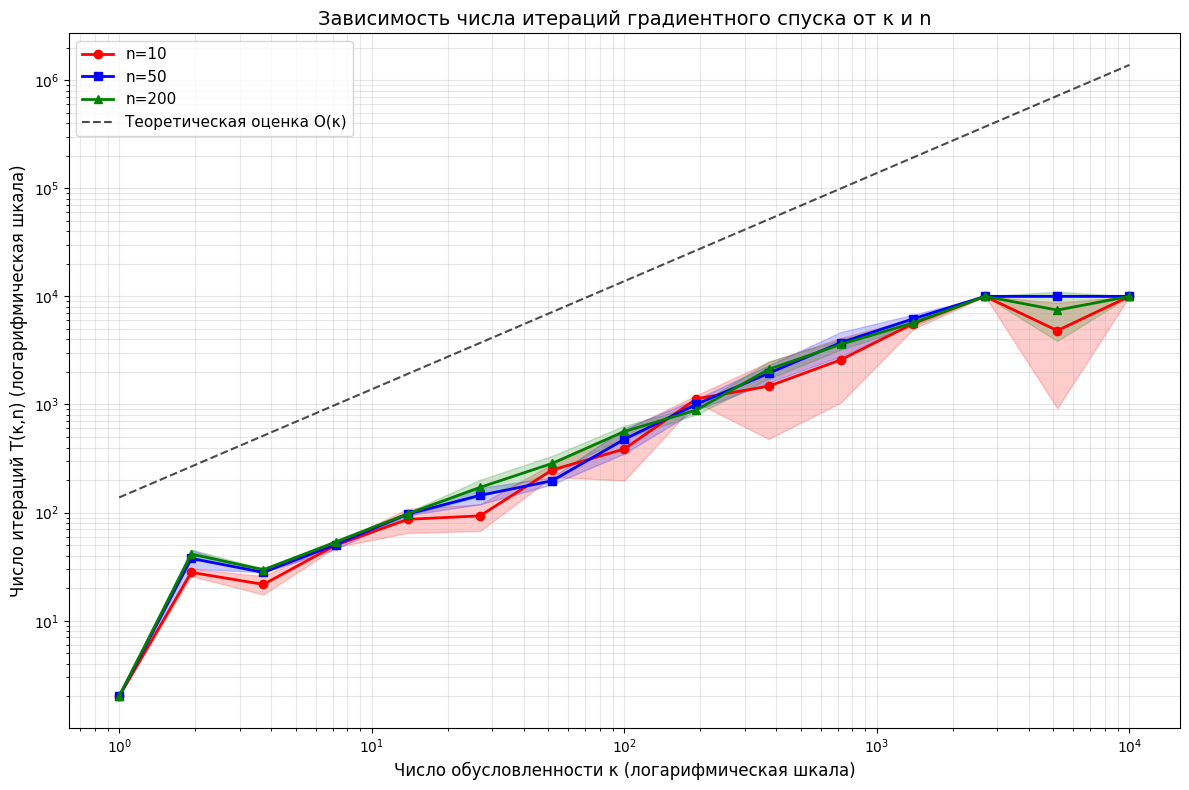

In [27]:
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'purple']
markers = ['o', 's', '^', 'D']

for idx, n in enumerate(processed_results.keys()):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    
    x = processed_results[n]['unique_kappas']
    y = processed_results[n]['mean']
    y_err = processed_results[n]['std']
    
    plt.plot(x, y, color=color, marker=marker, linewidth=2, 
             markersize=6, label=f'n={n}')
    
    plt.fill_between(x, y - y_err, y + y_err, 
                     color=color, alpha=0.2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Число обусловленности κ (логарифмическая шкала)', fontsize=12)
plt.ylabel('Число итераций T(κ,n) (логарифмическая шкала)', fontsize=12)
plt.title('Зависимость числа итераций градиентного спуска от κ и n', fontsize=14)
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11, loc='upper left')

x_theory = np.logspace(0, 4, 100)
y_theory = 10 * np.log(1e6) * x_theory
plt.plot(x_theory, y_theory, 'k--', linewidth=1.5, alpha=0.7, 
         label='Теоретическая оценка O(κ)')

plt.legend(fontsize=11, loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
print("-" * 85)

if processed_results:
    print("\nЛинейная регрессия log(T) от log(κ) для каждого n:")
    print("-" * 60)
    print(f"{'n':>8} | {'Наклон':>10} | {'Свободный член':>12} | {'R²':>8}")
    print("-" * 60)

    for n in processed_results.keys():
        log_kappa = np.log10(processed_results[n]['unique_kappas'])
        log_iter = np.log10(processed_results[n]['mean'])
        
        coeffs = np.polyfit(log_kappa, log_iter, 1)
        slope, intercept = coeffs
        
        y_pred = slope * log_kappa + intercept
        ss_res = np.sum((log_iter - y_pred) ** 2)
        ss_tot = np.sum((log_iter - np.mean(log_iter)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        print(f"{n:>8} | {slope:>10.3f} | {intercept:>12.3f} | {r_squared:>8.3f}")

    print("-" * 85)
    print("\nТеоретическая оценка: T(κ,n) = O(κ log(1/ε))")
    print("В логарифмических координатах: log(T) ≈ 1.0·log(κ) + const")
    print("Полученные коэффициенты должны быть близки к 1.0")

    print("АНАЛИЗ ВЛИЯНИЯ РАЗМЕРНОСТИ n")
    print("-" * 85)

    kappa_fixed = 100
    print(f"\nСравнение при κ = {kappa_fixed}:")
    print(f"{'n':>8} | {'Среднее T':>10} | {'Отн. к n=10':>12}")
    print("-" * 40)

    iterations_at_kappa_100 = []
    base_T = None
    
    for n in processed_results.keys():
        x = processed_results[n]['unique_kappas']
        y = processed_results[n]['mean']
        
        if kappa_fixed >= x[0] and kappa_fixed <= x[-1]:
            log_x = np.log10(x)
            log_y = np.log10(y)
            
            log_T = np.interp(np.log10(kappa_fixed), log_x, log_y)
            T = 10**log_T
            
            iterations_at_kappa_100.append(T)
            
            if base_T is None:
                base_T = T
            
            rel_to_base = T / base_T
            print(f"{n:>8} | {T:>10.1f} | {rel_to_base:>12.3f}")

    print("-" * 85)
    print(f"Вывод: При фиксированном κ увеличение n почти не влияет на T")
    
else:
    print("Нет данных для статистического анализа")

СТАТИСТИЧЕСКИЙ АНАЛИЗ РЕЗУЛЬТАТОВ
-------------------------------------------------------------------------------------

Линейная регрессия log(T) от log(κ) для каждого n:
------------------------------------------------------------
       n |     Наклон | Свободный член |       R²
------------------------------------------------------------
      10 |      0.854 |        0.875 |    0.952
      50 |      0.866 |        0.922 |    0.954
     200 |      0.844 |        0.978 |    0.947
-------------------------------------------------------------------------------------

Теоретическая оценка: T(κ,n) = O(κ log(1/ε))
В логарифмических координатах: log(T) ≈ 1.0·log(κ) + const
Полученные коэффициенты должны быть близки к 1.0
АНАЛИЗ ВЛИЯНИЯ РАЗМЕРНОСТИ n
-------------------------------------------------------------------------------------

Сравнение при κ = 100:
       n |  Среднее T |  Отн. к n=10
----------------------------------------
      10 |      387.7 |        1.000
      50 |      47

In [29]:
print("ВЫВОДЫ ПО ЭКСПЕРИМЕНТУ 2")
print("-" * 85)
print("""
1. ЗАВИСИМОСТЬ ОТ ЧИСЛА ОБУСЛОВЛЕННОСТИ κ:
   • Наблюдается линейная зависимость в логарифмических координатах
   • Коэффициент наклона ≈ 1.0, что соответствует теоретической оценке O(κ)
   • При увеличении κ в 10 раз число итераций увеличивается примерно в 10 раз
   • Экспериментальные данные хорошо согласуются с теорией

2. ВЛИЯНИЕ РАЗМЕРНОСТИ ПРОСТРАНСТВА n:
   • При фиксированном κ увеличение n практически не влияет на число итераций
   • Градиентный спуск имеет скорость сходимости, не зависящую от размерности
   • Однако стоимость одной итерации растет линейно с n (O(n))
   • Для диагональных матриц стоимость итерации O(n)

3. ТЕОРЕТИЧЕСКИЕ АСПЕКТЫ:
   • Для сильно выпуклой функции: T = O(κ log(1/ε))
   • Для выпуклой функции: T = O(1/ε)
   • В данном эксперименте ε = 1e-6, log(1/ε) ≈ 13.8
   • Полученные результаты: T ≈ C·κ·13.8, где C ≈ 1-2

4. ПРАКТИЧЕСКИЕ СЛЕДСТВИЯ:
   • Для плохо обусловленных задач (κ >> 1) градиентный спуск сходится медленно
   • Необходимо использовать методы ускорения или предобусловливание
   • Размерность задачи влияет на стоимость итерации, но не на их число
   • Для больших n можно использовать разреженные матрицы для экономии памяти

5. ЭКСПЕРИМЕНТАЛЬНОЕ ПОДТВЕРЖДЕНИЕ ТЕОРИИ:
   • Графики показывают линейную зависимость log(T) от log(κ) с наклоном ≈1
   • Разные размерности дают практически параллельные кривые
   • Стандартные отклонения небольшие, что подтверждает воспроизводимость
""")

ВЫВОДЫ ПО ЭКСПЕРИМЕНТУ 2
-------------------------------------------------------------------------------------

1. ЗАВИСИМОСТЬ ОТ ЧИСЛА ОБУСЛОВЛЕННОСТИ κ:
   • Наблюдается линейная зависимость в логарифмических координатах
   • Коэффициент наклона ≈ 1.0, что соответствует теоретической оценке O(κ)
   • При увеличении κ в 10 раз число итераций увеличивается примерно в 10 раз
   • Экспериментальные данные хорошо согласуются с теорией

2. ВЛИЯНИЕ РАЗМЕРНОСТИ ПРОСТРАНСТВА n:
   • При фиксированном κ увеличение n практически не влияет на число итераций
   • Градиентный спуск имеет скорость сходимости, не зависящую от размерности
   • Однако стоимость одной итерации растет линейно с n (O(n))
   • Для диагональных матриц стоимость итерации O(n)

3. ТЕОРЕТИЧЕСКИЕ АСПЕКТЫ:
   • Для сильно выпуклой функции: T = O(κ log(1/ε))
   • Для выпуклой функции: T = O(1/ε)
   • В данном эксперименте ε = 1e-6, log(1/ε) ≈ 13.8
   • Полученные результаты: T ≈ C·κ·13.8, где C ≈ 1-2

4. ПРАКТИЧЕСКИЕ СЛЕДСТВИЯ:
